In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
from torch import nn
from torch import optim
import os

In [3]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def carregar_dadosv2(train_data, test_data, test_size=0.2, random_state=42):
    # Load data from CSV file
    train_data = pd.read_csv(train_data)
    val_data = pd.read_csv(test_data)

    # Split data into features (X) and targets (y)
    X = train_data.drop(['hysteresis', 'joule'], axis=1)
    y = train_data[['hysteresis', 'joule']]

    # Perform train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_test = val_data.drop(['hysteresis', 'joule'], axis=1)
    y_test = val_data[['hysteresis', 'joule']]

    # Convert data to numpy arrays
    X_train_np = X_train.to_numpy()
    y_train_np = y_train.to_numpy()
    X_val_np = X_val.to_numpy()
    y_val_np = y_val.to_numpy()
    X_test_np = X_test.to_numpy()
    y_test_np = y_test.to_numpy()

    return X_train_np, y_train_np, X_val_np, y_val_np, X_test_np, y_test_np

In [4]:
import matplotlib.pyplot as plt


def plot_comparacao(y_true, y_pred):

    plt.figure(figsize=(8, 6))

    # Plot each target separately
    for i in range(2):  # Assuming two targets
        plt.scatter([true[i] for true in y_true], [pred[i] for pred in y_pred], label=f'Target {i+1}', alpha=0.5)

    max_val = max(max(y_true[:,0]), max(y_pred[:,0]), max(y_true[:,1]), max(y_pred[:,1]))
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Reference Line')

    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Comparison between True and Predicted Values')
    plt.legend()

    plt.show()


In [5]:
!pip install xgboost


In [6]:
import xgboost as xgb
from xgboost import XGBRegressor

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

folder_path = '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs/2D'
os.chdir(folder_path)

X_train ,y_train, X_val, y_val,X_test,y_test = carregar_dadosv2('dados_de_treino.csv','dados_de_teste.csv')

train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_val, label=y_val)
verify_test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.18438088025284619,
    'max_depth': 7,
    'subsample': 0.816395068974634,
    'colsample_bytree': 0.9741558370628208,
    'gamma': 1.9349140709821284e-05,
    'min_child_weight': 4
}
input_size = X_train.shape[1]
output_size = y_train.shape[1]

def objective(trial):
    params = {
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7)
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
    predictions = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    return rmse




In [7]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [8]:
#import optuna
#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=100)

In [9]:
num_boost_round = 1000
watchlist = [(train_dmatrix, 'train'), (test_dmatrix, 'eval')]
bst = xgb.train(params, train_dmatrix, num_boost_round, watchlist, early_stopping_rounds=10)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:0.81350	eval-rmse:0.82017
[1]	train-rmse:0.67001	eval-rmse:0.67565
[2]	train-rmse:0.56038	eval-rmse:0.56606
[3]	train-rmse:0.46356	eval-rmse:0.46848
[4]	train-rmse:0.38467	eval-rmse:0.38916
[5]	train-rmse:0.32060	eval-rmse:0.32520
[6]	train-rmse:0.28988	eval-rmse:0.29544
[7]	train-rmse:0.24318	eval-rmse:0.24880
[8]	train-rmse:0.20574	eval-rmse:0.21151
[9]	train-rmse:0.17694	eval-rmse:0.18291
[10]	train-rmse:0.15840	eval-rmse:0.16531
[11]	train-rmse:0.13718	eval-rmse:0.14494
[12]	train-rmse:0.12650	eval-rmse:0.13517
[13]	train-rmse:0.11109	eval-rmse:0.12069
[14]	train-rmse:0.09948	eval-rmse:0.10980
[15]	train-rmse:0.09017	eval-rmse:0.10140
[16]	train-rmse:0.08181	eval-rmse:0.09386
[17]	train-rmse:0.07504	eval-rmse:0.08795
[18]	train-rmse:0.07017	eval-rmse:0.08387
[19]	train-rmse:0.06622	eval-rmse:0.08062
[20]	train-rmse:0.06277	eval-rmse:0.07770
[21]	train-rmse:0.05966	eval-rmse:0.07517
[22]	train-rmse:0.05716	eval-rmse:0.07323
[23]	train-rmse:0.05508	eval-rmse:0.07172
[2

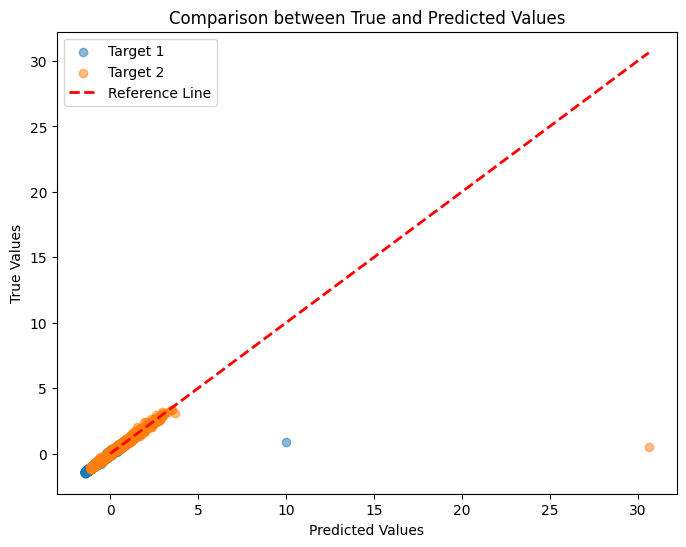

In [10]:
predictions = bst.predict(verify_test_dmatrix)
plot_comparacao(y_test,predictions)